In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure display settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load the data
# Note: Replace 'walmart_sales.csv' with your actual file path
df = pd.read_csv('walmart_cleaned.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully!
Dataset shape: (421570, 17)


In [2]:
print("\n" + "="*80)
print("1. BASIC DATA EXPLORATION")
print("="*80)

print("\nDataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset shape:", df.shape)
print(f"Number of unique stores: {df['Store'].nunique()}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found in the dataset!")


print("\nBasic Statistics:")
print(df.describe())


1. BASIC DATA EXPLORATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    421570 non-null  int64  
 1   Store         421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   IsHoliday     421570 non-null  int64  
 4   Dept          421570 non-null  float64
 5   Weekly_Sales  421570 non-null  float64
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  Type          421570 non-null  int64  
 16  Size          421570 non-null  int64  
dtypes: flo

In [3]:
print("\n" + "="*80)
print("2. DATA PREPROCESSING")
print("="*80)

df['Date'] = pd.to_datetime(df['Date'])


df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day_of_Year'] = df['Date'].dt.dayofyear


df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

print("Date preprocessing completed!")
print(f"Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")



2. DATA PREPROCESSING
Date preprocessing completed!
Date range: 2010-02-05 to 2012-10-26


In [4]:
print("\n" + "="*80)
print("3. EXPLORATORY DATA ANALYSIS")
print("="*80)


3. EXPLORATORY DATA ANALYSIS


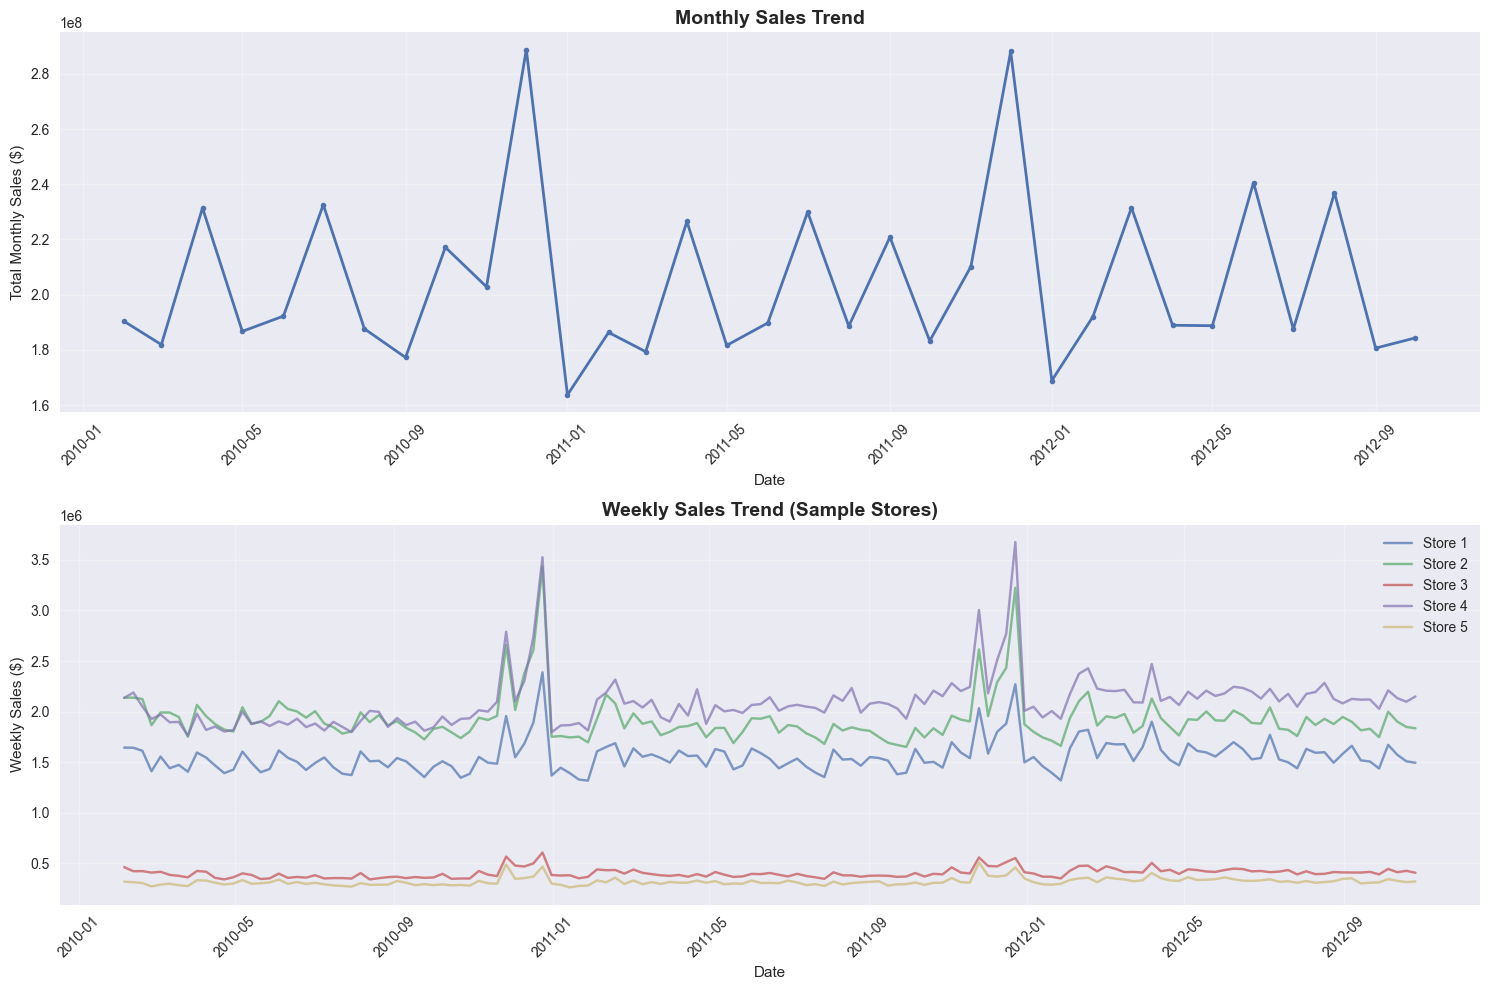

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Monthly Sales Trend
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1))

axes[0].plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'], marker='o', linewidth=2, markersize=4)
axes[0].set_title('Monthly Sales Trend', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Monthly Sales ($)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Weekly Sales Over Time (Sample of stores)
sample_stores = df['Store'].unique()[:5]
for store in sample_stores:
    store_data = df[df['Store'] == store].groupby('Date')['Weekly_Sales'].sum().reset_index()
    axes[1].plot(store_data['Date'], store_data['Weekly_Sales'], alpha=0.7, label=f'Store {store}')

axes[1].set_title('Weekly Sales Trend (Sample Stores)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weekly Sales ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

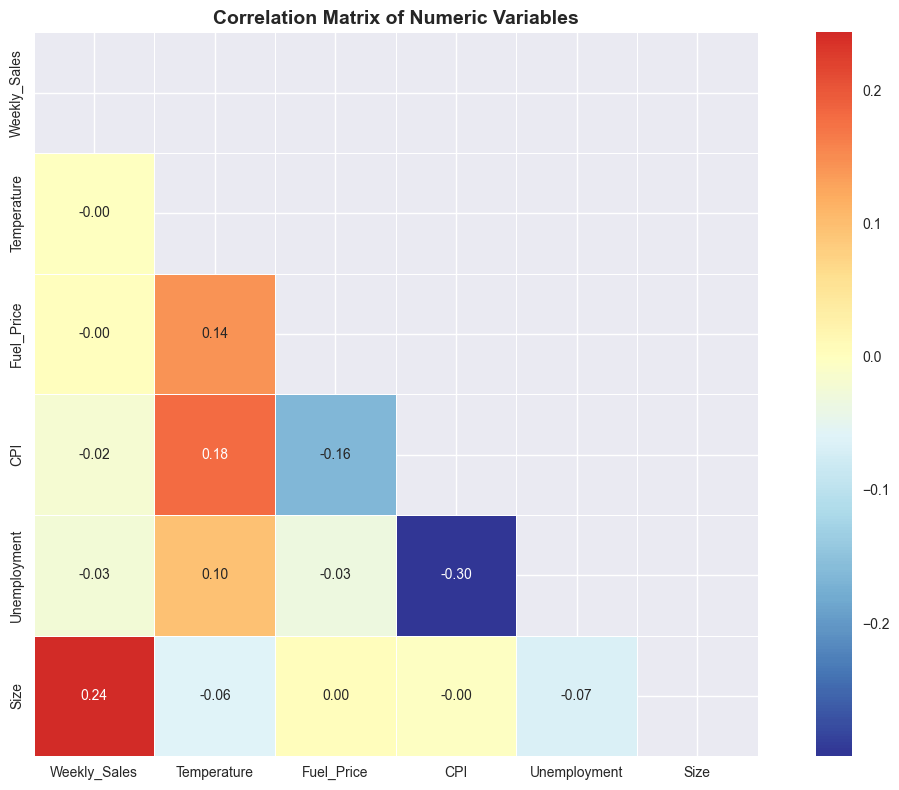

In [6]:
plt.figure(figsize=(12, 8))
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
correlation_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=.5, fmt='.2f')
plt.title('Correlation Matrix of Numeric Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

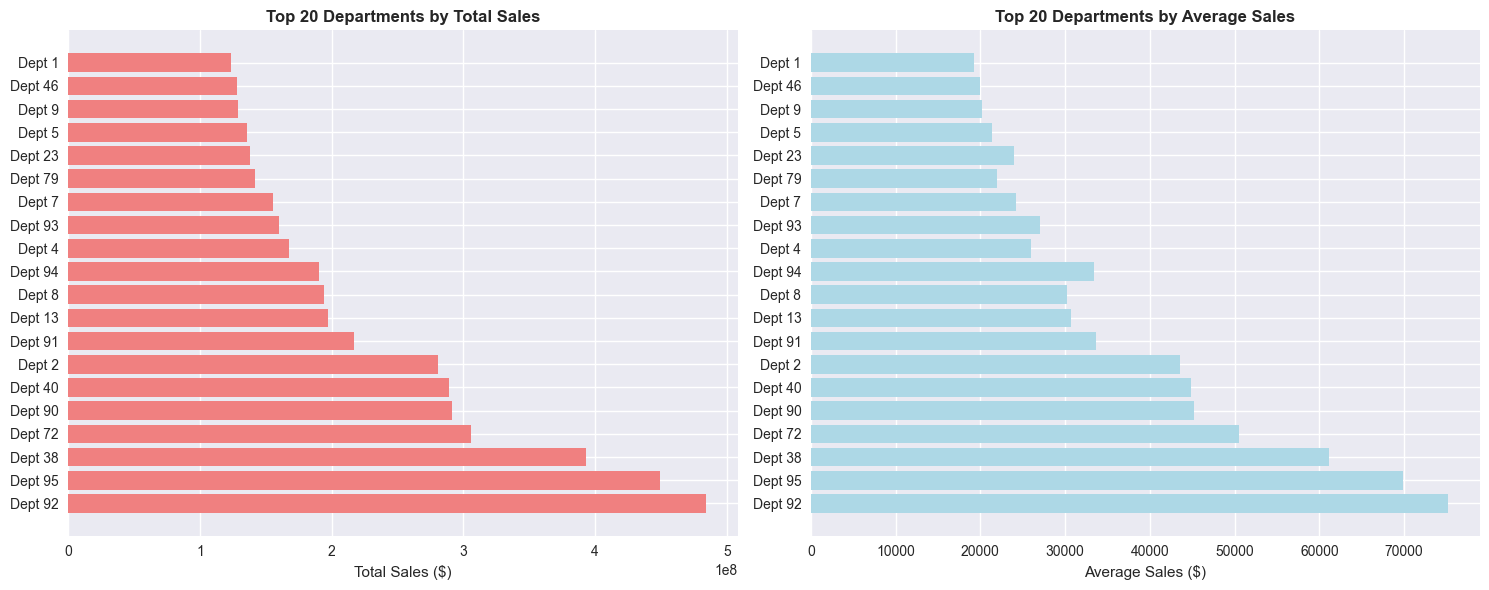

In [7]:
dept_sales = df.groupby('Dept')['Weekly_Sales'].agg(['sum', 'mean', 'count']).reset_index()
dept_sales = dept_sales.sort_values('sum', ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 20 Departments by Total Sales
axes[0].barh(range(len(dept_sales)), dept_sales['sum'], color='lightcoral')
axes[0].set_yticks(range(len(dept_sales)))
axes[0].set_yticklabels([f"Dept {int(d)}" for d in dept_sales['Dept']])
axes[0].set_title('Top 20 Departments by Total Sales', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Sales ($)')

# Average Sales by Department
axes[1].barh(range(len(dept_sales)), dept_sales['mean'], color='lightblue')
axes[1].set_yticks(range(len(dept_sales)))
axes[1].set_yticklabels([f"Dept {int(d)}" for d in dept_sales['Dept']])
axes[1].set_title('Top 20 Departments by Average Sales', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Sales ($)')

plt.tight_layout()
plt.show()

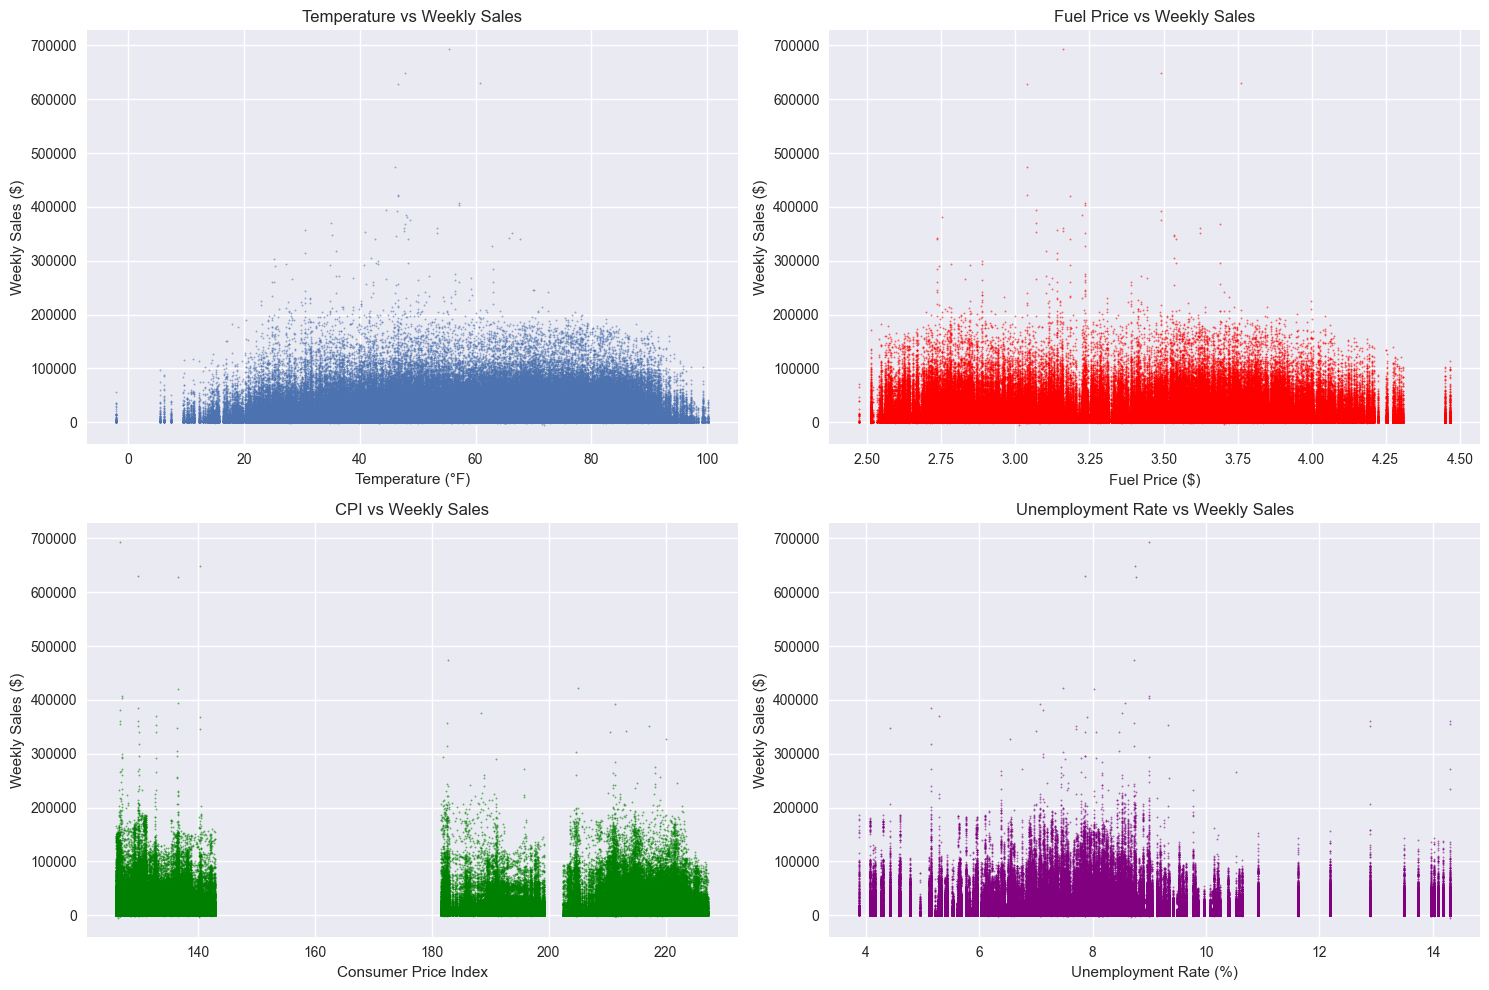

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature vs Sales
axes[0, 0].scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.5, s=1)
axes[0, 0].set_title('Temperature vs Weekly Sales')
axes[0, 0].set_xlabel('Temperature (°F)')
axes[0, 0].set_ylabel('Weekly Sales ($)')

# Fuel Price vs Sales
axes[0, 1].scatter(df['Fuel_Price'], df['Weekly_Sales'], alpha=0.5, s=1, color='red')
axes[0, 1].set_title('Fuel Price vs Weekly Sales')
axes[0, 1].set_xlabel('Fuel Price ($)')
axes[0, 1].set_ylabel('Weekly Sales ($)')

# CPI vs Sales
axes[1, 0].scatter(df['CPI'], df['Weekly_Sales'], alpha=0.5, s=1, color='green')
axes[1, 0].set_title('CPI vs Weekly Sales')
axes[1, 0].set_xlabel('Consumer Price Index')
axes[1, 0].set_ylabel('Weekly Sales ($)')

# Unemployment vs Sales
axes[1, 1].scatter(df['Unemployment'], df['Weekly_Sales'], alpha=0.5, s=1, color='purple')
axes[1, 1].set_title('Unemployment Rate vs Weekly Sales')
axes[1, 1].set_xlabel('Unemployment Rate (%)')
axes[1, 1].set_ylabel('Weekly Sales ($)')

plt.tight_layout()
plt.show()

In [9]:
print("\n" + "="*80)
print("4. ANOMALY DETECTION")
print("="*80)


4. ANOMALY DETECTION


In [10]:
df_anomaly = df.copy()

# 4.1 Statistical Outliers using IQR Method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in Weekly Sales
sales_outliers, lower_bound, upper_bound = detect_outliers_iqr(df_anomaly, 'Weekly_Sales')
print(f"Number of sales outliers (IQR method): {len(sales_outliers)}")
print(f"Sales outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# 4.2 Z-Score Method
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column]))
    outliers = data[z_scores > threshold]
    return outliers, z_scores

sales_outliers_z, z_scores = detect_outliers_zscore(df_anomaly, 'Weekly_Sales')
print(f"Number of sales outliers (Z-score method, threshold=3): {len(sales_outliers_z)}")

# 4.3 Isolation Forest for Multivariate Anomaly Detection
# Prepare features for isolation forest
features_for_anomaly = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
X = df_anomaly[features_for_anomaly].copy()

# Handle any potential missing values
X = X.fillna(X.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
anomaly_labels = isolation_forest.fit_predict(X_scaled)

# Add anomaly labels to dataframe
df_anomaly['Anomaly_IF'] = anomaly_labels
df_anomaly['Anomaly_Score'] = isolation_forest.score_samples(X_scaled)

# Count anomalies
n_anomalies_if = len(df_anomaly[df_anomaly['Anomaly_IF'] == -1])
print(f"Number of anomalies detected by Isolation Forest: {n_anomalies_if}")

# 4.4 Domain-Specific Anomaly Detection
# Detect negative sales (should not exist)
negative_sales = df_anomaly[df_anomaly['Weekly_Sales'] < 0]
print(f"Number of negative sales records: {len(negative_sales)}")

# Detect extremely high sales (potential data entry errors)
very_high_sales = df_anomaly[df_anomaly['Weekly_Sales'] > df_anomaly['Weekly_Sales'].quantile(0.999)]
print(f"Number of extremely high sales (>99.9th percentile): {len(very_high_sales)}")

Number of sales outliers (IQR method): 35521
Sales outlier bounds: [-25109.65, 47395.16]
Number of sales outliers (Z-score method, threshold=3): 8848
Number of anomalies detected by Isolation Forest: 21079
Number of negative sales records: 1285
Number of extremely high sales (>99.9th percentile): 422


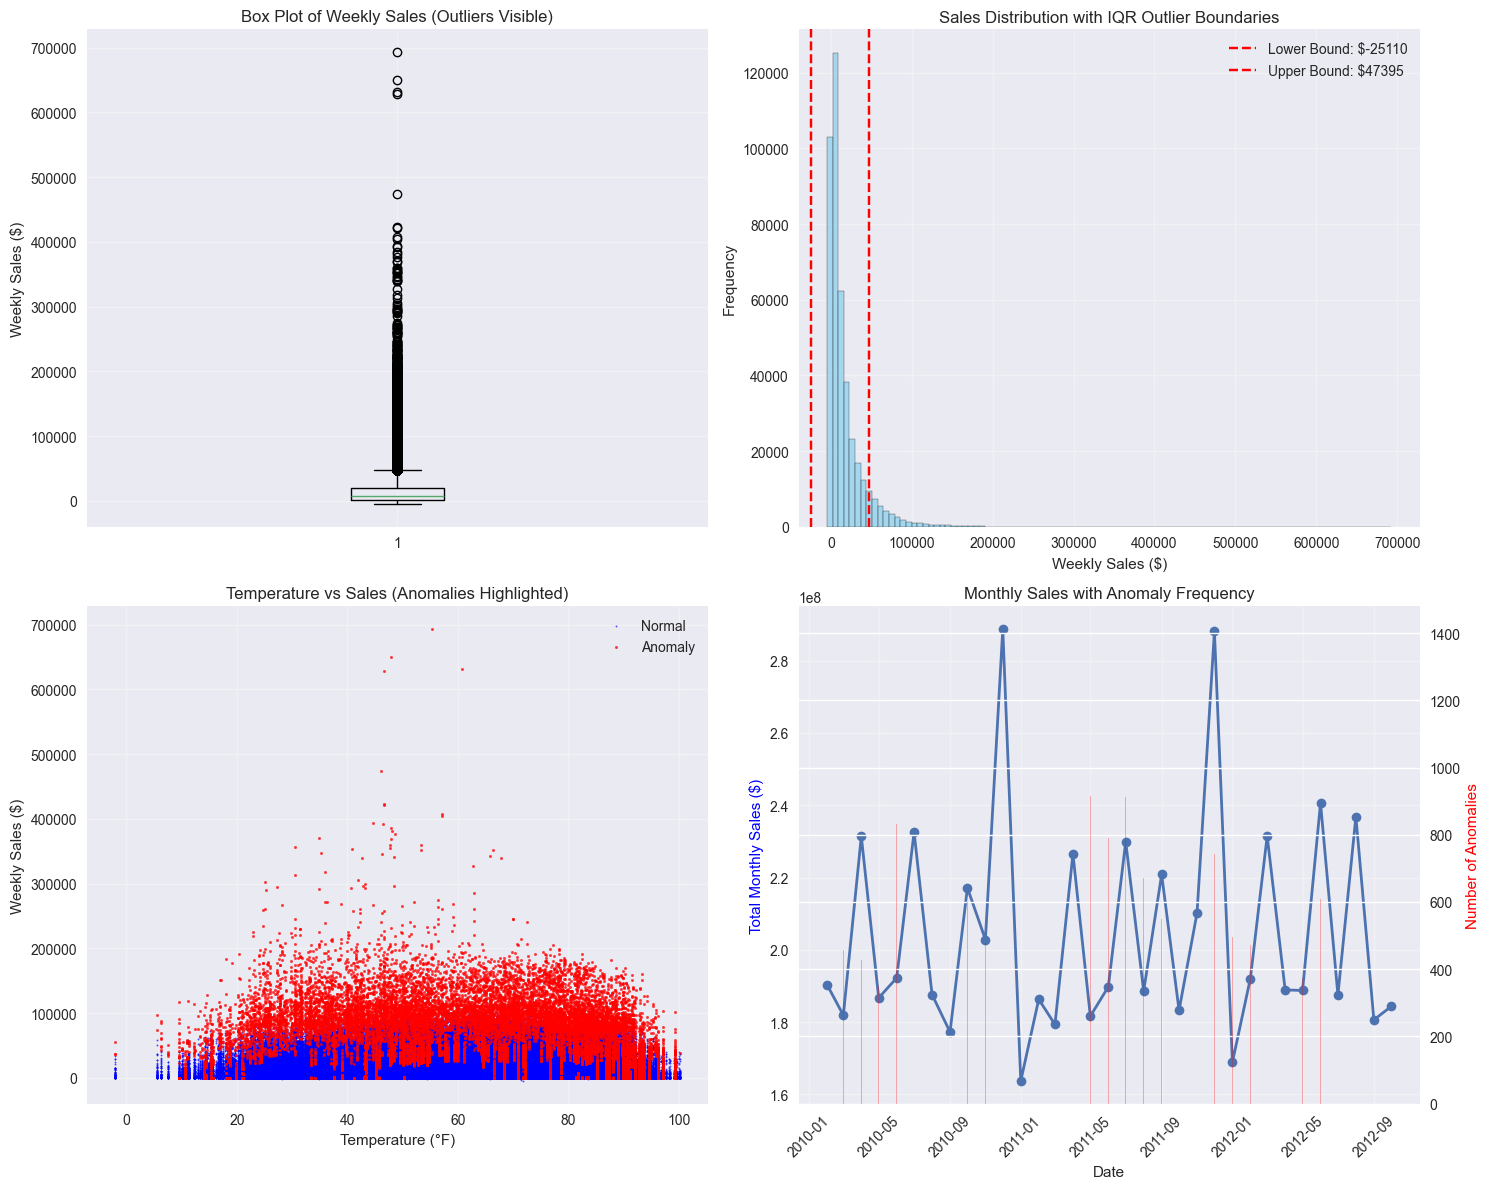

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Box plot for sales outliers
axes[0, 0].boxplot(df_anomaly['Weekly_Sales'])
axes[0, 0].set_title('Box Plot of Weekly Sales (Outliers Visible)')
axes[0, 0].set_ylabel('Weekly Sales ($)')
axes[0, 0].grid(True, alpha=0.3)

# Histogram with outlier boundaries
axes[0, 1].hist(df_anomaly['Weekly_Sales'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: ${lower_bound:.0f}')
axes[0, 1].axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: ${upper_bound:.0f}')
axes[0, 1].set_title('Sales Distribution with IQR Outlier Boundaries')
axes[0, 1].set_xlabel('Weekly Sales ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot colored by anomaly detection
normal_points = df_anomaly[df_anomaly['Anomaly_IF'] == 1]
anomaly_points = df_anomaly[df_anomaly['Anomaly_IF'] == -1]

axes[1, 0].scatter(normal_points['Temperature'], normal_points['Weekly_Sales'], 
                  alpha=0.6, s=1, color='blue', label='Normal')
axes[1, 0].scatter(anomaly_points['Temperature'], anomaly_points['Weekly_Sales'], 
                  alpha=0.8, s=3, color='red', label='Anomaly')
axes[1, 0].set_title('Temperature vs Sales (Anomalies Highlighted)')
axes[1, 0].set_xlabel('Temperature (°F)')
axes[1, 0].set_ylabel('Weekly Sales ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series with anomalies
monthly_anomalies = df_anomaly[df_anomaly['Anomaly_IF'] == -1].groupby(['Year', 'Month']).size().reset_index(name='Anomaly_Count')
monthly_anomalies['Date'] = pd.to_datetime(monthly_anomalies[['Year', 'Month']].assign(day=1))

axes[1, 1].plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'], marker='o', linewidth=2, label='Total Sales')
ax2 = axes[1, 1].twinx()
ax2.bar(monthly_anomalies['Date'], monthly_anomalies['Anomaly_Count'], alpha=0.3, color='red', label='Anomaly Count')
axes[1, 1].set_title('Monthly Sales with Anomaly Frequency')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Total Monthly Sales ($)', color='blue')
ax2.set_ylabel('Number of Anomalies', color='red')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
print("\n" + "="*80)
print("5. ANOMALY ANALYSIS AND INSIGHTS")
print("="*80)

# Analyze anomalies by store
anomaly_by_store = df_anomaly[df_anomaly['Anomaly_IF'] == -1].groupby('Store').size().reset_index(name='Anomaly_Count')
anomaly_by_store = anomaly_by_store.sort_values('Anomaly_Count', ascending=False)

print("\nTop 10 Stores with Most Anomalies:")
print(anomaly_by_store.head(10))

# Analyze anomalies by department
anomaly_by_dept = df_anomaly[df_anomaly['Anomaly_IF'] == -1].groupby('Dept').size().reset_index(name='Anomaly_Count')
anomaly_by_dept = anomaly_by_dept.sort_values('Anomaly_Count', ascending=False)

print("\nTop 10 Departments with Most Anomalies:")
print(anomaly_by_dept.head(10))

# Analyze anomalies by holiday
anomaly_by_holiday = df_anomaly[df_anomaly['Anomaly_IF'] == -1].groupby('IsHoliday').size().reset_index(name='Anomaly_Count')
print("\nAnomalies by Holiday Status:")
print(anomaly_by_holiday)

# Statistical summary of anomalies
print("\nStatistical Summary of Anomalous Records:")
anomalous_records = df_anomaly[df_anomaly['Anomaly_IF'] == -1]
print(anomalous_records[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe())


5. ANOMALY ANALYSIS AND INSIGHTS

Top 10 Stores with Most Anomalies:
    Store  Anomaly_Count
27     28           3431
11     12           2985
37     38           2009
3       4           1433
13     14            946
19     20            847
9      10            812
22     23            810
12     13            770
1       2            668

Top 10 Departments with Most Anomalies:
    Dept  Anomaly_Count
71  92.0           2961
74  95.0           2659
36  38.0           1932
69  90.0           1412
59  72.0           1266
1    2.0            924
37  40.0            879
70  91.0            659
7    8.0            475
73  94.0            438

Anomalies by Holiday Status:
   IsHoliday  Anomaly_Count
0          0          19459
1          1           1620

Statistical Summary of Anomalous Records:
        Weekly_Sales   Temperature    Fuel_Price           CPI  Unemployment
count   21079.000000  21079.000000  21079.000000  21079.000000  21079.000000
mean    68164.308643     64.545800     

In [13]:

print("\n" + "="*80)
print("6. ANOMALY REMOVAL AND DATA CLEANING")
print("="*80)

# Create cleaned dataset
df_cleaned = df_anomaly.copy()

# Remove records based on different criteria
print("Dataset cleaning options:")
print(f"Original dataset size: {len(df_cleaned)}")

# Option 1: Remove Isolation Forest anomalies
df_option1 = df_cleaned[df_cleaned['Anomaly_IF'] == 1].copy()
print(f"After removing Isolation Forest anomalies: {len(df_option1)} records")

# Option 2: Remove IQR outliers in sales
df_option2 = df_cleaned[(df_cleaned['Weekly_Sales'] >= lower_bound) & 
                       (df_cleaned['Weekly_Sales'] <= upper_bound)].copy()
print(f"After removing IQR outliers in sales: {len(df_option2)} records")

# Option 3: Conservative approach - remove only extreme cases
df_option3 = df_cleaned[
    (df_cleaned['Weekly_Sales'] >= 0) &  # Remove negative sales
    (df_cleaned['Weekly_Sales'] <= df_cleaned['Weekly_Sales'].quantile(0.995))  # Remove top 0.5%
].copy()
print(f"After conservative cleaning (negative sales and top 0.5%): {len(df_option3)} records")

# For this analysis, let's use Option 1 (Isolation Forest)
df_final = df_option1.copy()

# Remove anomaly detection columns
columns_to_remove = ['Anomaly_IF', 'Anomaly_Score']
df_final = df_final.drop(columns=columns_to_remove)

print(f"\nFinal cleaned dataset size: {len(df_final)} records")
print(f"Records removed: {len(df) - len(df_final)} ({((len(df) - len(df_final))/len(df)*100):.2f}%)")



6. ANOMALY REMOVAL AND DATA CLEANING
Dataset cleaning options:
Original dataset size: 421570
After removing Isolation Forest anomalies: 400491 records
After removing IQR outliers in sales: 386049 records
After conservative cleaning (negative sales and top 0.5%): 418177 records

Final cleaned dataset size: 400491 records
Records removed: 21079 (5.00%)



7. COMPARISON: BEFORE AND AFTER CLEANING


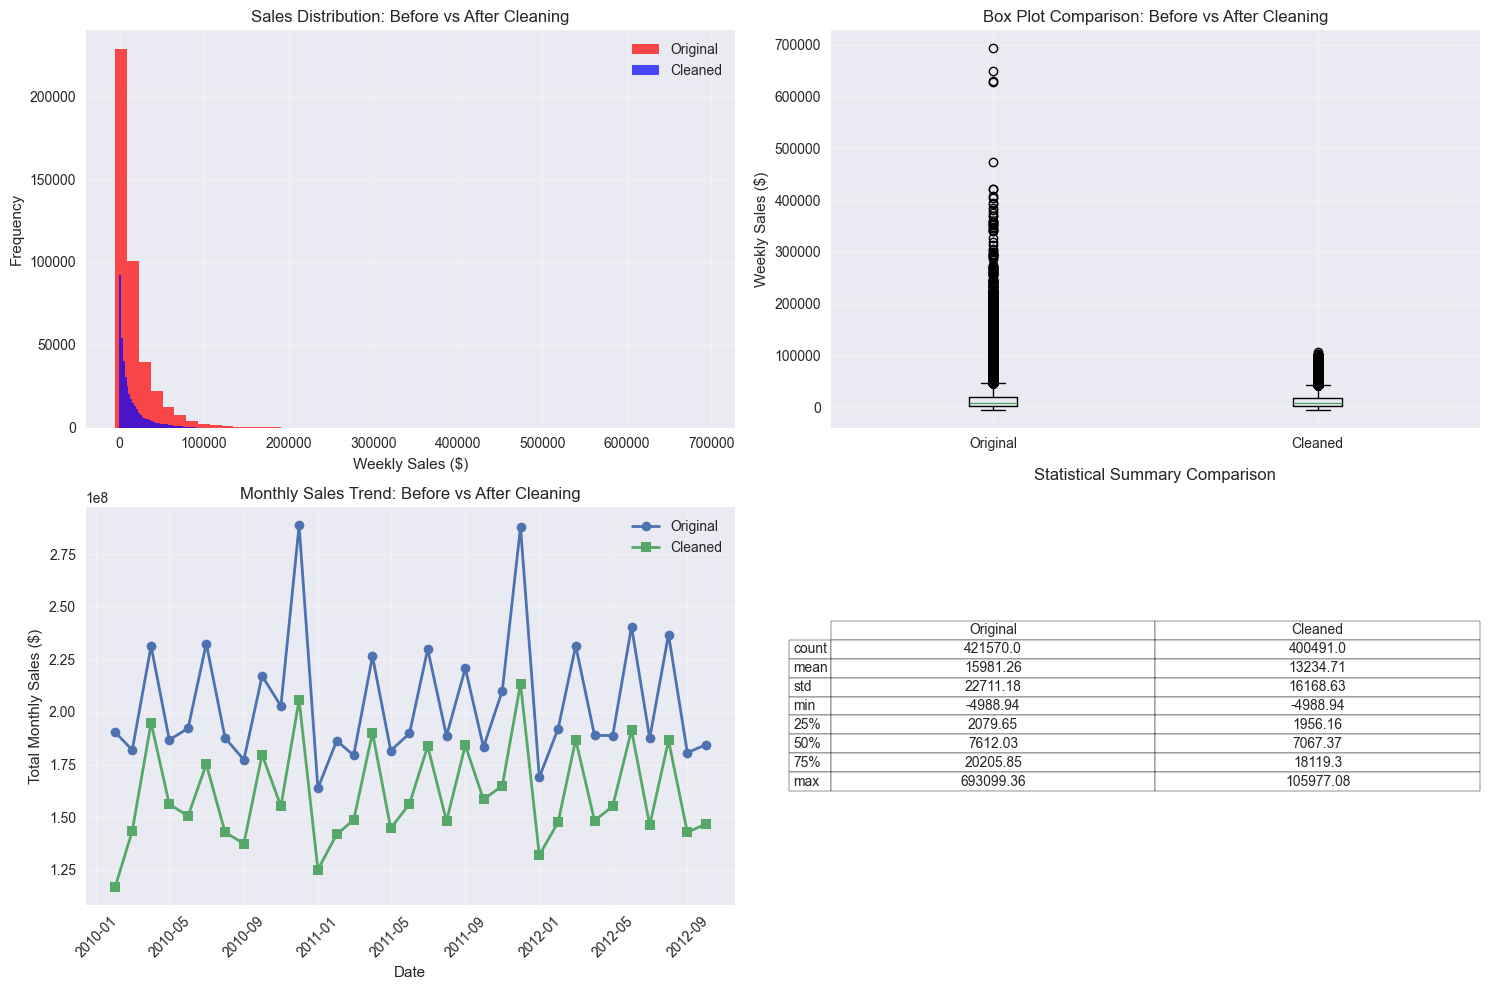


Statistical Comparison:
            Original        Cleaned
count  421570.000000  400491.000000
mean    15981.258123   13234.713203
std     22711.183519   16168.627275
min     -4988.940000   -4988.940000
25%      2079.650000    1956.160000
50%      7612.030000    7067.370000
75%     20205.852500   18119.300000
max    693099.360000  105977.080000


In [14]:
print("\n" + "="*80)
print("7. COMPARISON: BEFORE AND AFTER CLEANING")
print("="*80)

# Compare basic statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales distribution comparison
axes[0, 0].hist(df['Weekly_Sales'], bins=50, alpha=0.7, label='Original', color='red')
axes[0, 0].hist(df_final['Weekly_Sales'], bins=50, alpha=0.7, label='Cleaned', color='blue')
axes[0, 0].set_title('Sales Distribution: Before vs After Cleaning')
axes[0, 0].set_xlabel('Weekly Sales ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot comparison
box_data = [df['Weekly_Sales'], df_final['Weekly_Sales']]
axes[0, 1].boxplot(box_data, labels=['Original', 'Cleaned'])
axes[0, 1].set_title('Box Plot Comparison: Before vs After Cleaning')
axes[0, 1].set_ylabel('Weekly Sales ($)')
axes[0, 1].grid(True, alpha=0.3)

# Monthly trend comparison
monthly_sales_original = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales_original['Date'] = pd.to_datetime(monthly_sales_original[['Year', 'Month']].assign(day=1))

monthly_sales_cleaned = df_final.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales_cleaned['Date'] = pd.to_datetime(monthly_sales_cleaned[['Year', 'Month']].assign(day=1))

axes[1, 0].plot(monthly_sales_original['Date'], monthly_sales_original['Weekly_Sales'], 
               marker='o', label='Original', linewidth=2)
axes[1, 0].plot(monthly_sales_cleaned['Date'], monthly_sales_cleaned['Weekly_Sales'], 
               marker='s', label='Cleaned', linewidth=2)
axes[1, 0].set_title('Monthly Sales Trend: Before vs After Cleaning')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Total Monthly Sales ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Statistical summary comparison
stats_comparison = pd.DataFrame({
    'Original': df['Weekly_Sales'].describe(),
    'Cleaned': df_final['Weekly_Sales'].describe()
})

axes[1, 1].axis('off')
axes[1, 1].table(cellText=np.round(stats_comparison.values, 2),
                rowLabels=stats_comparison.index,
                colLabels=stats_comparison.columns,
                cellLoc='center',
                loc='center')
axes[1, 1].set_title('Statistical Summary Comparison', pad=20)

plt.tight_layout()
plt.show()

print("\nStatistical Comparison:")
print(stats_comparison)

In [15]:
print("\n" + "="*80)
print("9. KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

print("\nKEY FINDINGS:")
print("="*50)

# Sales insights
avg_sales_original = df['Weekly_Sales'].mean()
avg_sales_cleaned = df_final['Weekly_Sales'].mean()
print(f"1. Average weekly sales (original): ${avg_sales_original:,.2f}")
print(f"   Average weekly sales (cleaned): ${avg_sales_cleaned:,.2f}")

# Holiday impact
holiday_impact = df_final.groupby('IsHoliday')['Weekly_Sales'].mean()
print(f"2. Holiday vs Non-Holiday average sales:")
print(f"   Non-Holiday: ${holiday_impact[0]:,.2f}")
print(f"   Holiday: ${holiday_impact[1]:,.2f}")
print(f"   Holiday lift: {((holiday_impact[1]/holiday_impact[0] - 1) * 100):+.1f}%")

# Top performing store types
store_performance = df_final.groupby('Type')['Weekly_Sales'].mean().sort_values(ascending=False)
print(f"3. Average sales by store type:")
for store_type, avg_sales in store_performance.items():
    print(f"   Type {store_type}: ${avg_sales:,.2f}")

# Seasonal patterns
seasonal_sales = df_final.groupby('Month')['Weekly_Sales'].mean()
peak_month = seasonal_sales.idxmax()
low_month = seasonal_sales.idxmin()
print(f"4. Seasonal patterns:")
print(f"   Peak sales month: {peak_month} (${seasonal_sales[peak_month]:,.2f})")
print(f"   Lowest sales month: {low_month} (${seasonal_sales[low_month]:,.2f})")

print("\nRECOMMENDations:")
print("="*50)
print("1. Focus marketing efforts during identified peak months")
print("2. Investigate anomalous stores/departments for potential issues or opportunities")
print("3. Consider seasonal inventory planning based on identified patterns")
print("4. Monitor economic indicators (CPI, unemployment) for sales forecasting")
print("5. Implement automated anomaly detection for real-time data quality monitoring")


9. KEY INSIGHTS AND RECOMMENDATIONS

KEY FINDINGS:
1. Average weekly sales (original): $15,981.26
   Average weekly sales (cleaned): $13,234.71
2. Holiday vs Non-Holiday average sales:
   Non-Holiday: $13,237.97
   Holiday: $13,191.41
   Holiday lift: -0.4%
3. Average sales by store type:
   Type 3: $16,023.96
   Type 2: $10,899.07
   Type 1: $8,325.25
4. Seasonal patterns:
   Peak sales month: 12 ($14,925.86)
   Lowest sales month: 1 ($11,467.79)

RECOMMENDations:
1. Focus marketing efforts during identified peak months
2. Investigate anomalous stores/departments for potential issues or opportunities
3. Consider seasonal inventory planning based on identified patterns
4. Monitor economic indicators (CPI, unemployment) for sales forecasting
5. Implement automated anomaly detection for real-time data quality monitoring


In [16]:
output_filename = 'walmart_sales_cleaned.csv'
df_final.to_csv(output_filename, index=False)
print(f"Cleaned dataset saved as: {output_filename}")

# Save anomaly report
anomaly_report = {
    'Total_Records_Original': len(df),
    'Total_Records_Cleaned': len(df_final),
    'Records_Removed': len(df) - len(df_final),
    'Removal_Percentage': ((len(df) - len(df_final))/len(df)*100),
    'Anomalies_by_Method': {
        'IQR_Outliers': len(sales_outliers),
        'Z_Score_Outliers': len(sales_outliers_z),
        'Isolation_Forest': n_anomalies_if,
        'Negative_Sales': len(negative_sales),
        'Extreme_High_Sales': len(very_high_sales)
    }
}

print("\nAnomalies Detection Summary:")
for method, count in anomaly_report['Anomalies_by_Method'].items():
    print(f"{method}: {count} anomalies")

print(f"\nTotal records removed: {anomaly_report['Records_Removed']} ({anomaly_report['Removal_Percentage']:.2f}%)")

Cleaned dataset saved as: walmart_sales_cleaned.csv

Anomalies Detection Summary:
IQR_Outliers: 35521 anomalies
Z_Score_Outliers: 8848 anomalies
Isolation_Forest: 21079 anomalies
Negative_Sales: 1285 anomalies
Extreme_High_Sales: 422 anomalies

Total records removed: 21079 (5.00%)
